<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_08_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используйте базу трафика с сайта компании. 

Напишите модель для прогнозирования трафика. 

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [1]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

In [3]:
#Загружаем и преобразовываем данные из csv файла
traf_dta = pd.read_csv('traff.csv',names=['date', 'traf'])
# Преобразование индекса в даты
traf_dta.index = pd.to_datetime(traf_dta.date)
# Удаление столбца даты
traf_dta.drop('date', axis=1, inplace=True)
traf_dta['traf']= traf_dta['traf'].str.replace(',','')
traf_dta['traf']= pd.to_numeric(traf_dta['traf'])
print(traf_dta.info())
print(traf_dta.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   traf    1095 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
None
               traf
date               
2017-01-01  22226.0
2017-01-02  29593.0
2017-01-03  31726.0
2017-01-04  32684.0
2017-01-05  31820.0
2017-01-06  29354.0
2017-01-07  29139.0
2017-01-08  31244.0
2017-01-09  32690.0
2017-01-10  31299.0


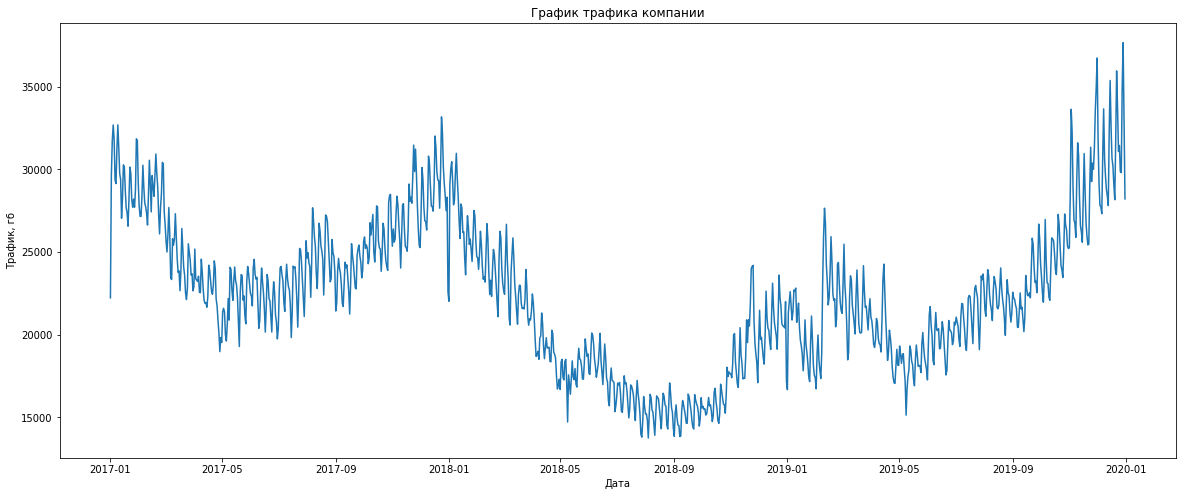

In [4]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(traf_dta)
plt.title('График трафика компании')
plt.xlabel('Дата')
plt.ylabel('Трафик, гб')
plt.show()

**Определение обучающей и тренировочной выборок**

In [5]:
# Преобразование в numpy-массив
data = np.array(traf_dta)

In [6]:
x_len = 60                          # Анализ по 60 прошедшим точкам 
val_len = 300                       # Использование 200 записей для проверки
train_len = data.shape[0] - val_len # Размер тренировочной выборки

# Формирование обучающей и тестовой выборок
x_data_train, x_data_test = data[:train_len], data[train_len + x_len+2:]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data[:train_len].reshape(-1,1), data[train_len + x_len+2:].reshape(-1,1) 

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=x_len,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=10)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=x_len,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=10)

Train data: (795, 1), (795, 1)
Test  data: (238, 1), (238, 1)


In [7]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=x_len,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (178, 60, 1), y: (178, 1)


### Сервисные функции


Опишем сервисные функции, которые упростят дальнейшие эксперименты с архитектурами НС:
- `get_pred()` – обученная модель. Предсказывает результат, который возвращается к ненормированным данным;
- `correlate()` – расчет коэффициента автокорреляции;
- `show_predict()` – построение графиков предсказания и верных ответов;
- `show_corr()` – построение графика автокорреляции;
- `eval_net()` – объединяет предыдущие функции и показывает результаты обучения сети;
- `train_eval_net()` – процесс обучения сети и вывод ее результатов. В обучении модели подаются не отдельные выборки, а сразу генераторы, так как они дают тот же результат, что и отдельные выборки. При этом уже нет необходимости прописывать размер батча обучения, поскольку он прописан в самом генераторе.

In [8]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [9]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


In [10]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=['traf'], # список имен каналов данных
                 title=''):
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    
    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn], 
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [11]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['traf'], 
              title=''): # список имен каналов данных
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)
    
    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [12]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):
  
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)
    
    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед 
    show_predict(y_pred[1:], y_true[:-1], start, length, 
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, 
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [13]:
# Функция обучения модели и отрисовки прогресса и оценки результатов 

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test, 
                   y_scaler, 
                   start=0, 
                   length=500, 
                   back_steps_max=50, 
                   title=''):
  
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, 
                            epochs=epochs, 
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, 
                 length=length, back_steps_max=back_steps_max, title=title)

#### Исследование №1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60, 150)           300       
                                                                 
 flatten (Flatten)           (None, 9000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9001      
                                                                 
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________
Обучение 50 эпох
Epoch 1/50
74/74 [==============================] - 3s 8ms/step - loss: 0.0288 - val_loss: 0.0214
Epoch 2/50
74/74 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0269
Epoch 3/50
74/74 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0173
Epoch 4

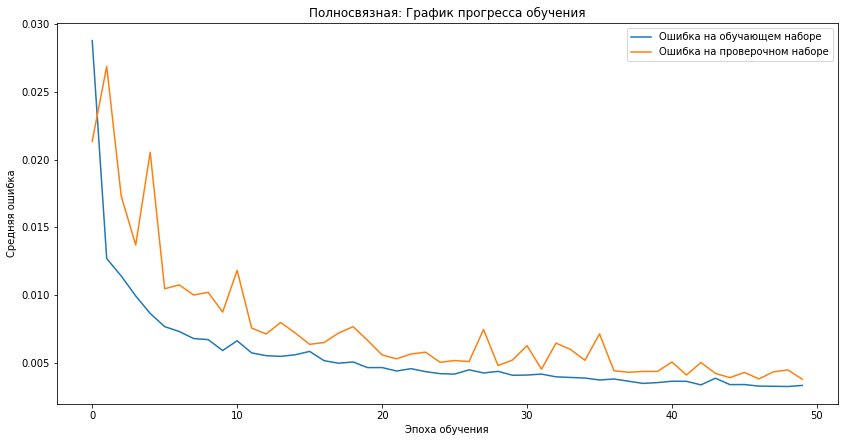

6/6 [==============================] - 0s 2ms/step


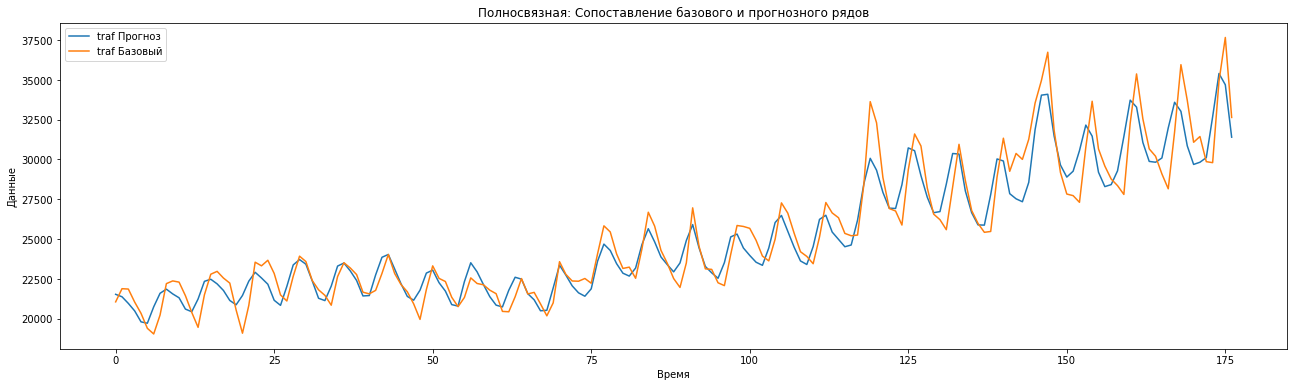

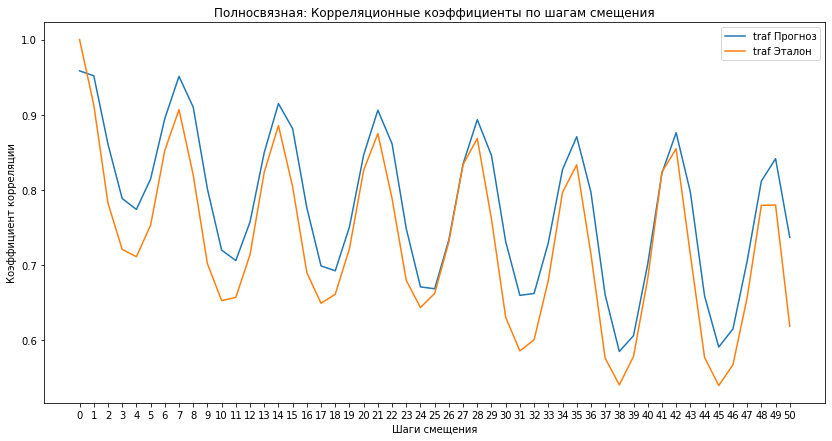

Обучение 50 эпох
Epoch 1/50
74/74 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 2/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 3/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 4/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 5/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 6/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 7/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 8/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 9/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 10/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0037
Ep

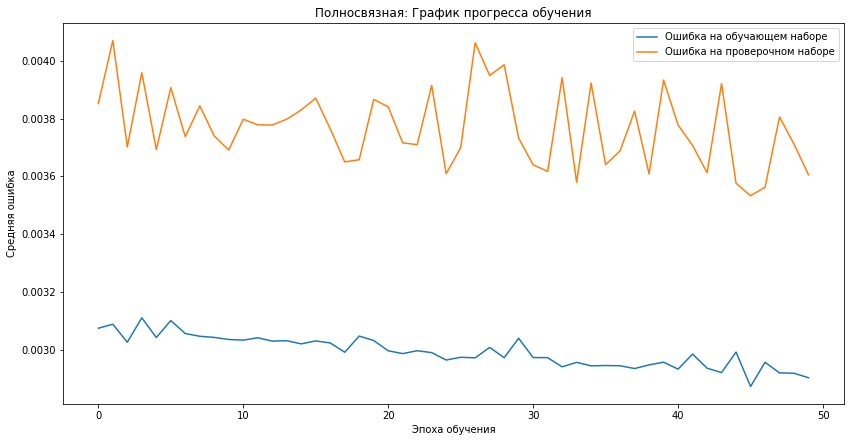

6/6 [==============================] - 0s 3ms/step


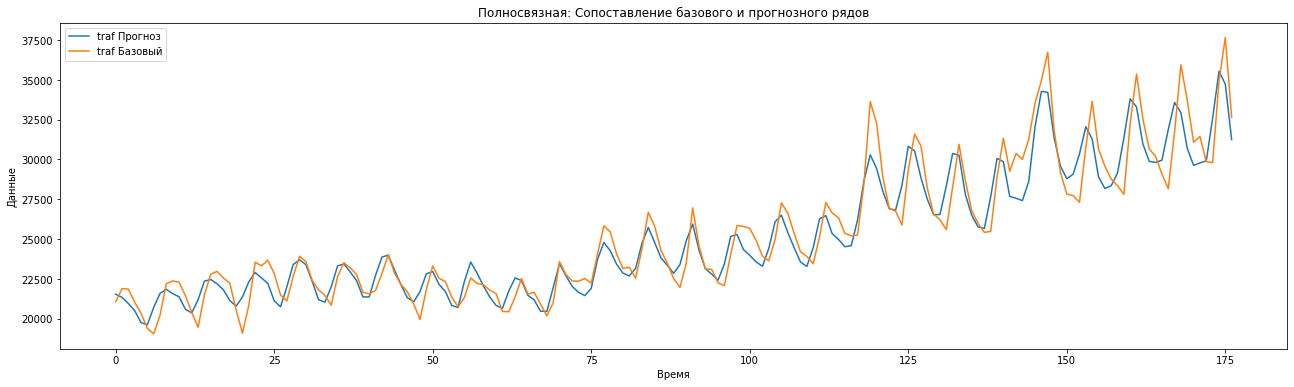

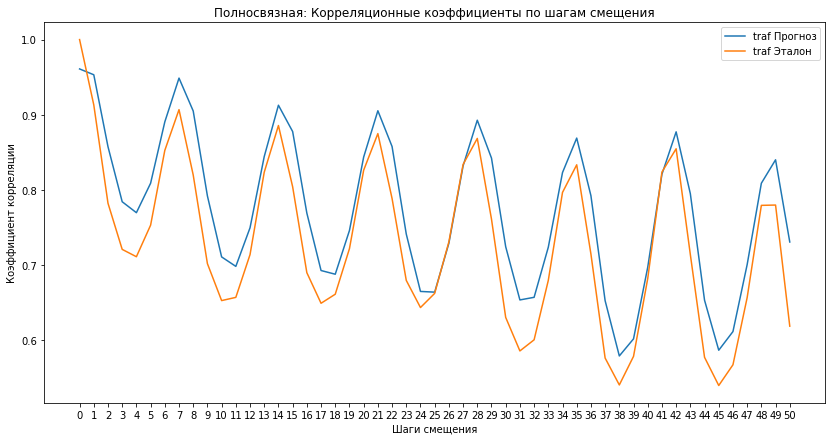

Обучение 50 эпох
Epoch 1/50
74/74 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 2/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 3/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 4/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 5/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 6/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 7/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 8/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 9/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 10/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0036
Ep

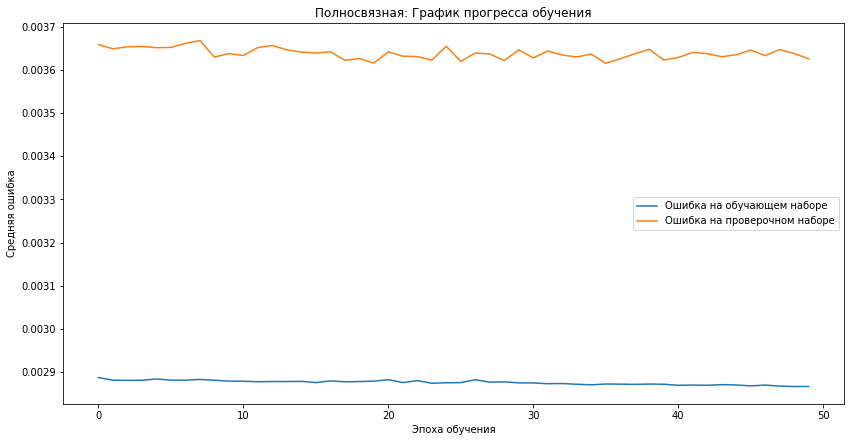

6/6 [==============================] - 0s 3ms/step


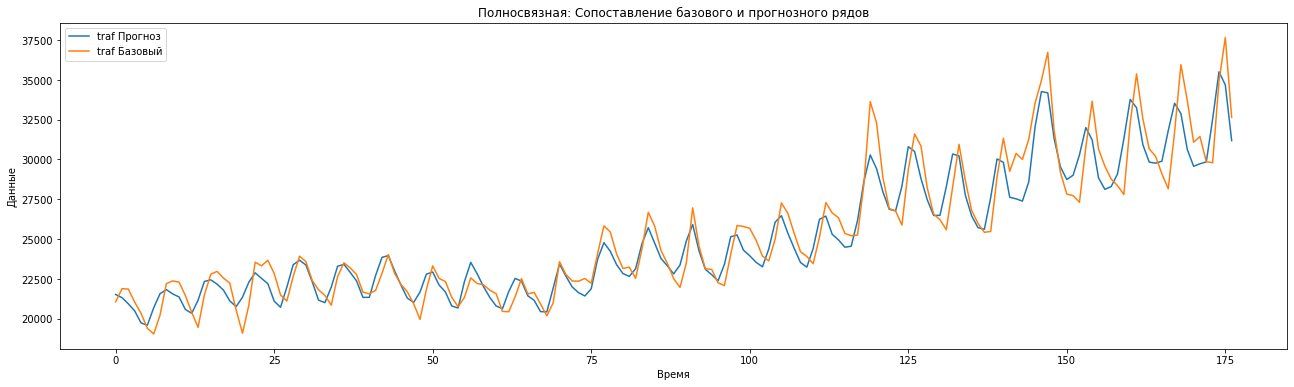

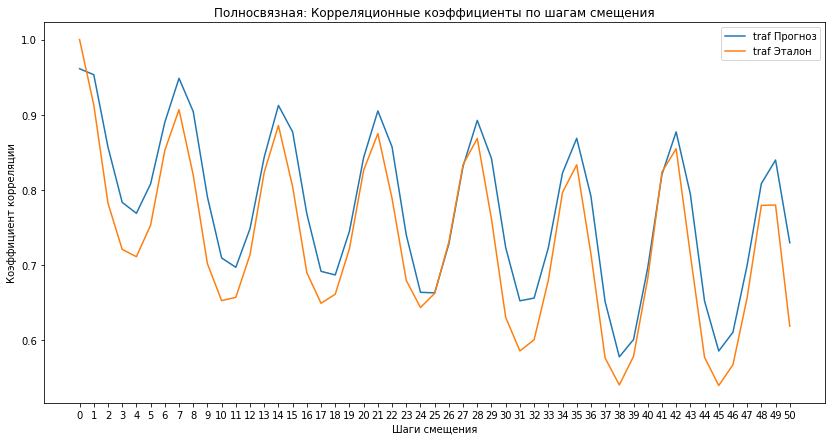

In [14]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen, val_datagen, [(50, Adam(lr=1e-4)),
                                                         (50, Adam(lr=1e-5)),
                                                         (50, Adam(lr=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

#### Исследование №2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 64)            384       
                                                                 
 conv1d_1 (Conv1D)           (None, 52, 128)           41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 128)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 3328)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               852224    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                      

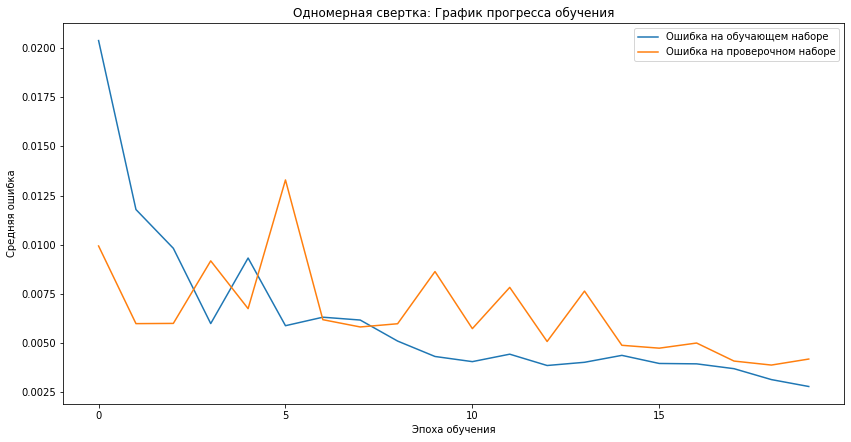

6/6 [==============================] - 0s 9ms/step


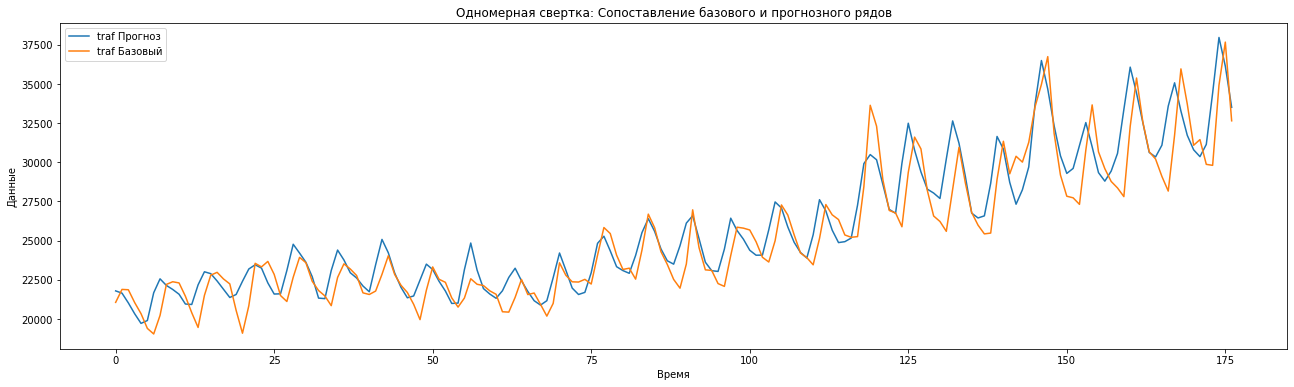

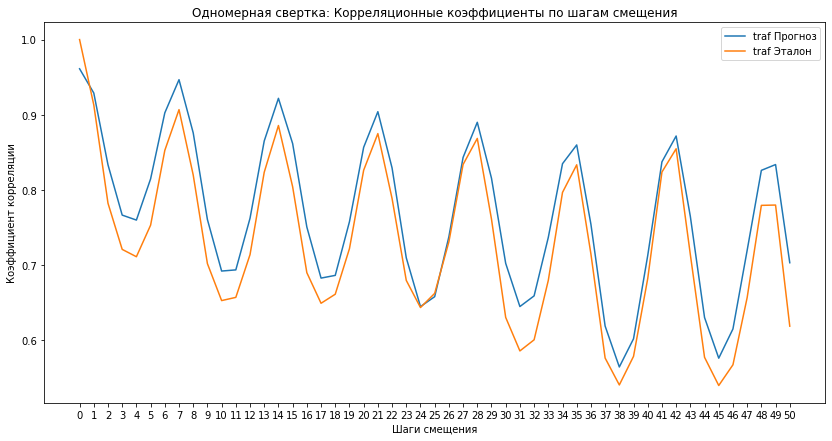

Обучение 20 эпох
Epoch 1/20
74/74 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 2/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 3/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 4/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 5/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 6/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 7/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 8/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 9/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 10/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0038
Ep

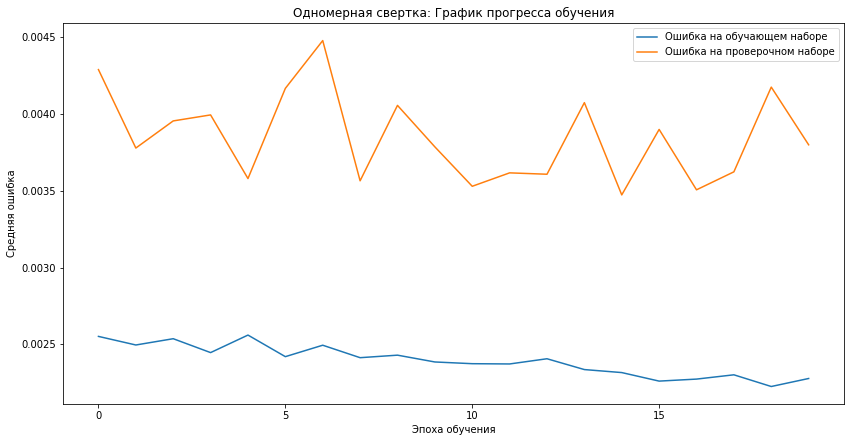

6/6 [==============================] - 0s 3ms/step


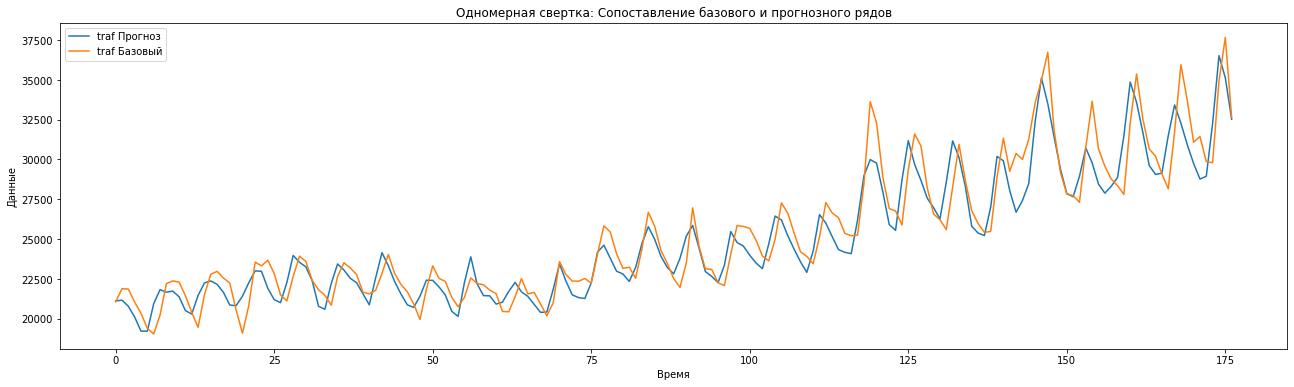

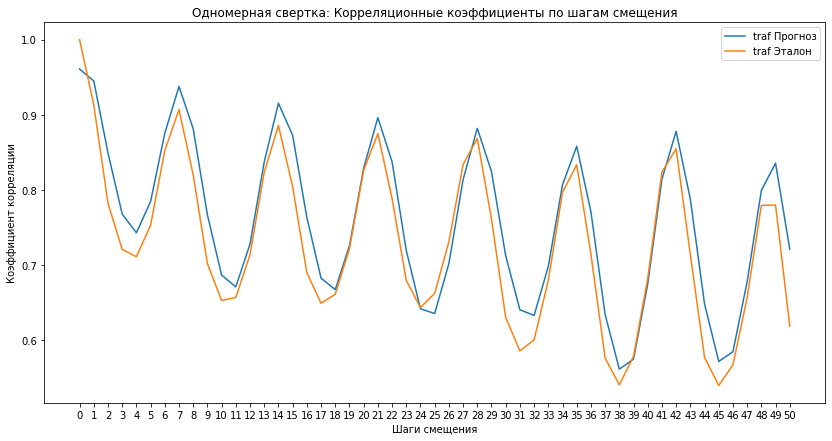

In [15]:
# Упрощенная модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv.add(Conv1D(128, 5, activation='linear'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(256, activation='linear'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 2x20 эпох
train_eval_net(model_conv, train_datagen, val_datagen, [(20, Adam(lr=1e-4)),
                                                          (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

#### Исследование №3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 56, 2048)          12288     
                                                                 
 flatten_2 (Flatten)         (None, 114688)            0         
                                                                 
 dense_4 (Dense)             (None, 1024)              117441536 
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 117,454,849
Trainable params: 117,454,849
Non-trainable params: 0
_________________________________________________________________
Обучение 10 эпох
Epoch 1/10
74/74 [==============================] - 3s 31ms/step - loss: 1.6949 - val_loss: 0.0678
Epoch 2/10
74/74 [==============================] - 2s 2

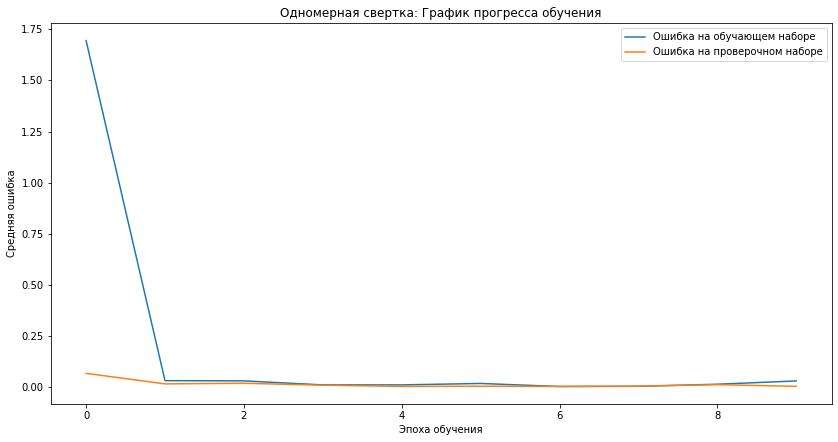

6/6 [==============================] - 0s 10ms/step


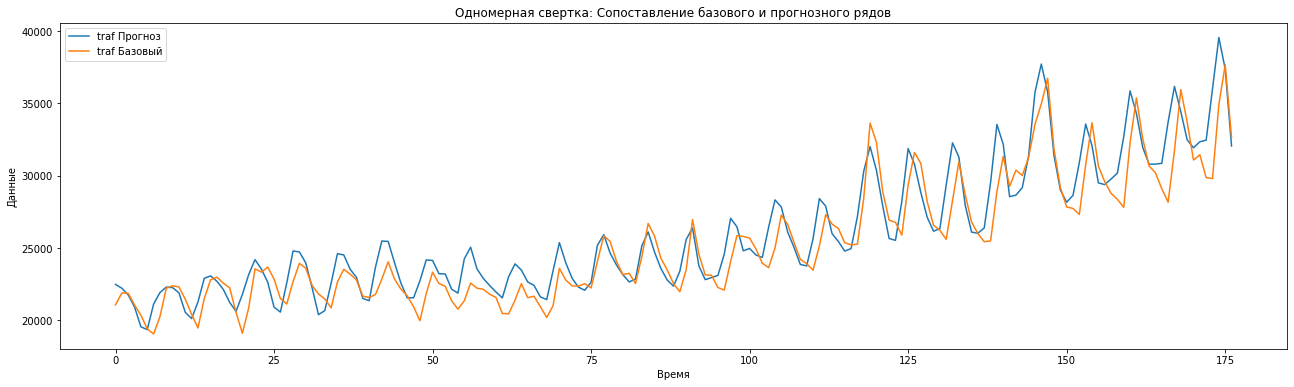

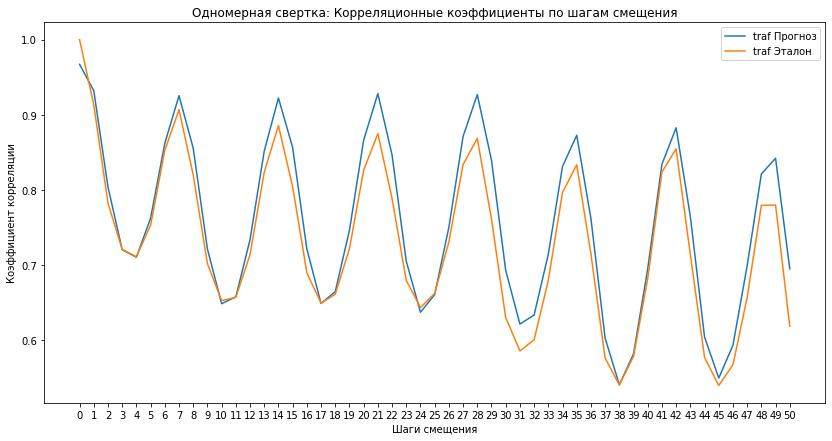

Обучение 20 эпох
Epoch 1/20
74/74 [==============================] - 3s 32ms/step - loss: 0.0159 - val_loss: 0.0039
Epoch 2/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0041 - val_loss: 0.0117
Epoch 3/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 4/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0105 - val_loss: 0.0043
Epoch 5/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 6/20
74/74 [==============================] - 2s 29ms/step - loss: 0.0048 - val_loss: 0.0097
Epoch 7/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0092 - val_loss: 0.0146
Epoch 8/20
74/74 [==============================] - 2s 29ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 9/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0048 - val_loss: 0.0114
Epoch 10/20
74/74 [==============================] - 2s 30ms/step - loss: 0.0034 - val_loss:

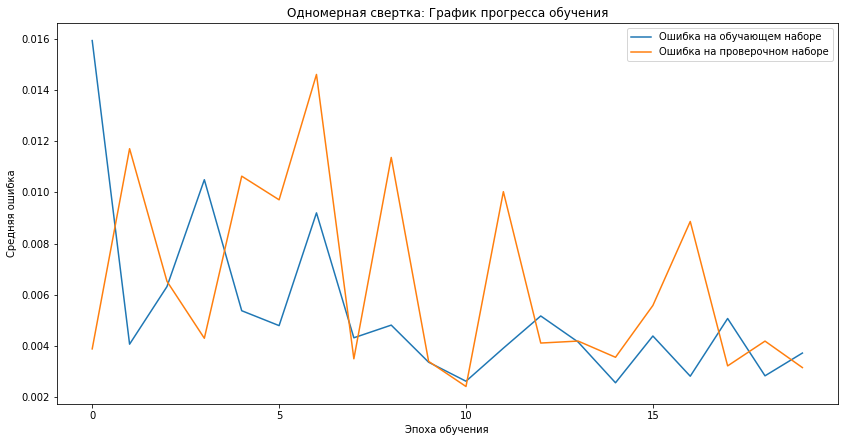

6/6 [==============================] - 0s 3ms/step


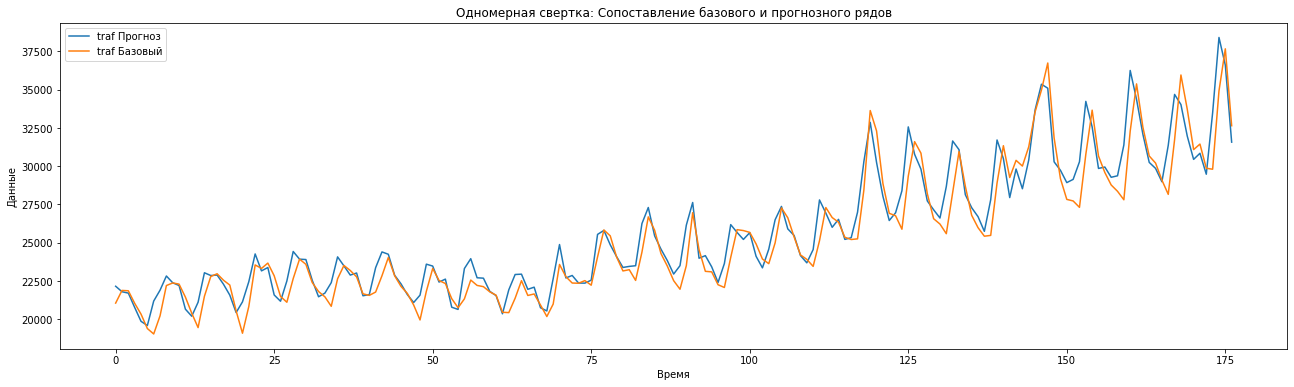

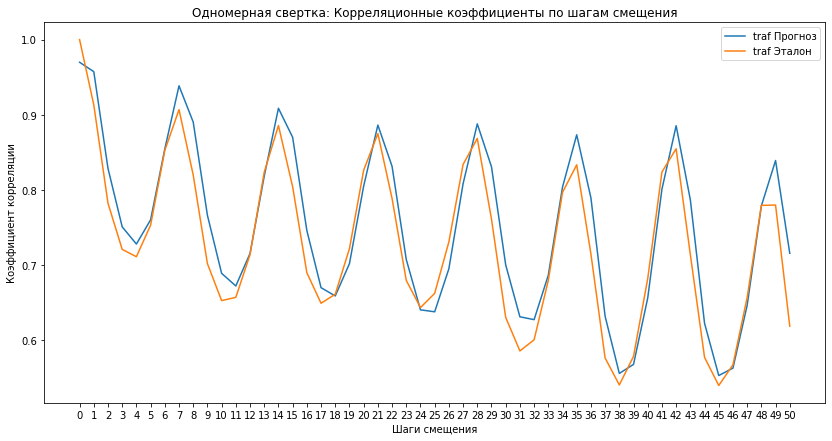

In [16]:
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(2048, 5, input_shape = (x_len,1), activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(1024, activation='linear'))
model_conv_2.add(Dense(1, activation='linear'))

# Обучение модели
train_eval_net(model_conv_2, train_datagen, val_datagen, [(10, Adam(lr=1e-4)),
                                                          (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

### Вывод: 

судя по результатам, опыт номер 2 оказался самым удачным, и в нем мы достигли максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.